In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
from training_database import get_player_features, get_all_players_for_round
import pandas as pd
df_info=get_player_features('Witsel', 14)

In [3]:
players_data = get_all_players_for_round(13)

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import numpy as np
import joblib
from sqlalchemy import create_engine

## 1. Get data

In [5]:
username = 'rodrigo'
host = 'localhost'           
port = '5432'               
database = 'futmondo_full_players_info'

engine = create_engine(f'postgresql+psycopg2://{username}@{host}:{port}/{database}')
# query = "SELECT * FROM full_training_data"
query= """SELECT *
    FROM full_training_data;"""

df = pd.read_sql(query, engine)
df.shape

(2064, 39)

In [7]:
df.columns

Index(['player_id', 'name', 'role', 'round', 'home_average', 'away_average',
       'overall_average', 'current_price', 'matches_played', 'rating',
       'team_id', 'match_minus_1', 'match_minus_2', 'last_2_average',
       'target_points', 'unique_id', 'team', 'matchup_prob_win',
       'matchup_prob_draw', 'matchup_prob_loss', 'is_home', 'opponent',
       'form_trend', 'home_away_diff', 'price_per_point', 'price_efficiency',
       'recent_momentum', 'home_form_interaction', 'away_form_interaction',
       'location_adjusted_average', 'matchup_strength',
       'team_expected_performance', 'delantero_matchup_bonus',
       'centrocampista_matchup_bonus', 'defensa_matchup_bonus',
       'portero_matchup_bonus', 'home_matchup_boost', 'difficult_matchup',
       'easy_matchup'],
      dtype='object')

In [30]:
df[['current_price', 'matches_played', 'rating',
       'team_id', 'match_minus_1', 'match_minus_2', 'last_2_average',
       'target_points', 'unique_id', 'team', 'matchup_prob_win']]

,current_price,matches_played,rating,team_id,match_minus_1,match_minus_2,last_2_average,target_points,unique_id,team,matchup_prob_win
0,1000000,2,1,504e581e4d8bec9a670000d2,0,0,0.0,0.0,85ba67b3355602579473ea43e3c5ed08846a5b438cc59a...,Mallorca,0.133968
1,1000000,7,1,51b889b1e401a15f2c0000f0,5,0,2.5,0.0,92bfb337584b85dccd9315123a2ac77153e7603ccb8db6...,Elche,0.125627
2,20975958,15,5,504e581e4d8bec9a670000cd,5,7,6.0,9.0,a50851f9607cfecf50a9a8d5d3687ecd243eea615fcf75...,Getafe,0.184276
3,1000000,1,1,504e581e4d8bec9a670000c8,4,0,2.0,0.0,4c38f479e6b83ed293b29a16776afa4707b1484a631ed8...,Ath Madrid,0.540120
4,5422151,12,3,504e581e4d8bec9a670000ce,7,2,4.5,0.0,e51b818714cb52a28e6a480539c364ec4e9dcf0647e309...,Sociedad,0.351882
...,...,...,...,...,...,...,...,...,...,...,...
2059,1000000,2,1,504e581e4d8bec9a670000d1,0,1,0.5,NaN,f1b33f22ffdf670ad242a7101bd4cfe1d4cb7d156c744e...,Osasuna,0.191783
2060,1000000,3,1,504e581e4d8bec9a670000c9,0,0,0.0,NaN,6d8788de5e6121e3c2d66dd5ac711536825ececc819729...,Ath Bilbao,0.369049
2061,1000000,1,1,52038563b8d07d930b00008a,0,0,0.0,NaN,27dc03fa2d38408976e1024da8b0018ee24a3f3db3e586...,Alaves,0.293541
2062,1060297,2,1,504e581e4d8bec9a670000d1,5,0,2.5,NaN,ae8618f33aff7e6ac8ef6134aa824f2f05bee71be72364...,Osasuna,0.191783


In [9]:
# df=pd.read_csv('data/final_dataset/futmondo_final_dataset.csv')
# df.shape

## 2. Build the model

In [10]:
# Corrected feature columns
feature_columns = [
    'home_average',
    'away_average', 
    'overall_average', 
    'last_2_average',  # Changed from last_3_average
    'current_price',
    'is_home',  # Removed is_home_target (duplicate)
    'match_minus_1',
    'match_minus_2',  # Removed match_minus_3 (not available)
    'matchup_prob_win', 
    'matchup_prob_draw', 
    'matchup_prob_loss', 
    'form_trend', 
    'home_away_diff', 
    'price_per_point',  # Changed from price_vs_max
    'price_efficiency',  # Changed from price_volatility
    'recent_momentum', 
    'home_form_interaction',
    'away_form_interaction',
    'location_adjusted_average',  # Added new feature
    'matchup_strength',
    'team_expected_performance', 
    'delantero_matchup_bonus',
    'centrocampista_matchup_bonus', 
    'defensa_matchup_bonus',
    'portero_matchup_bonus', 
    'home_matchup_boost', 
    'difficult_matchup',
    'easy_matchup'
]

# Drop rows where target_points or any feature is NaN
df_clean = df.dropna(subset=['target_points'] + feature_columns)
X = df_clean[feature_columns]
y = df_clean['target_points']

In [11]:
df_clean.shape

(1529, 39)

In [12]:
# # Check for NaN values first
# print("NaN values per column:")
# print(X.isna().sum())
# print(f"\nTotal NaN values: {X.isna().sum().sum()}")

# # Option 1: Drop rows with NaN values (if not too many)
# X_clean = X.dropna()
# y_clean = y[X_clean.index]

# print(f"\nRows before: {len(X)}, Rows after: {len(X_clean)}")

In [13]:
# Scale features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Ensemble model with multiple algorithms
gb_model = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

ridge_model = Ridge(alpha=10.0, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

# Voting ensemble combines predictions from all models
model = VotingRegressor(
    estimators=[
        ('gb', gb_model),
        ('rf', rf_model),
        ('ridge', ridge_model)
    ],
    weights=[2, 2, 1]  # Give more weight to tree-based models
)

# Train the ensemble
model.fit(X_train, y_train)

,estimators,"[('gb', ...), ('rf', ...), ...]"
,weights,"[2, 2, ...]"
,n_jobs,None
,verbose,False
,loss,'squared_error'
,learning_rate,0.05
,n_estimators,150
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10
,min_samples_leaf,4


In [14]:
# ===== PREDICTIONS =====
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Create predictions dataframe for test set
test_indices = len(y_test)
predictions_df = pd.DataFrame({
    'actual_points': y_test,
    'predicted_points': y_pred_test,
    'error': y_test - y_pred_test,
    'abs_error': np.abs(y_test - y_pred_test)})

In [15]:
# # Add original features (unscaled) for context
# X_test_unscaled = X.iloc[y_test.index] if hasattr(y_test, 'index') else X.iloc[-len(y_test):]
# predictions_df = pd.concat([predictions_df.reset_index(drop=True), 
#                             X_test_unscaled.reset_index(drop=True)], axis=1)

# print("===== PREDICTIONS SAMPLE =====")
# print(predictions_df[['actual_points', 'predicted_points', 'error', 'abs_error', 
#                       'overall_average', 'last_3_average', 'is_home_target']].head(10))
# print(f"\nMean Absolute Error: {predictions_df['abs_error'].mean():.3f}")
# print(f"Root Mean Squared Error: {np.sqrt((predictions_df['error']**2).mean()):.3f}")

In [16]:
# ===== FEATURE IMPORTANCE =====
# Access the fitted models from the VotingRegressor
gb_importance = model.named_estimators_['gb'].feature_importances_
rf_importance = model.named_estimators_['rf'].feature_importances_

# Average importance across models
avg_importance = (gb_importance * 2 + rf_importance * 2) / 4

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': avg_importance,
    'gb_importance': gb_importance,
    'rf_importance': rf_importance
}).sort_values('importance', ascending=False)

print("\n===== FEATURE IMPORTANCE =====")
print(feature_importance_df)


===== FEATURE IMPORTANCE =====
                         feature  importance  gb_importance  rf_importance
4                  current_price    0.201380       0.293943       0.108816
18     location_adjusted_average    0.118080       0.113213       0.122947
15               recent_momentum    0.060003       0.044833       0.075172
6                  match_minus_1    0.057182       0.045679       0.068685
2                overall_average    0.055670       0.043566       0.067775
11                    form_trend    0.045849       0.057304       0.034393
0                   home_average    0.039638       0.023718       0.055559
3                 last_2_average    0.037104       0.018093       0.056115
13               price_per_point    0.036748       0.030973       0.042523
1                   away_average    0.034893       0.024131       0.045656
12                home_away_diff    0.032829       0.036179       0.029480
14              price_efficiency    0.031774       0.020670       0.

Save the model

In [24]:
import joblib

# After training your model
model_package = {
    'model': model,
    'scaler': scaler,
    'feature_columns': feature_columns
}

joblib.dump(model_package, '../data/model/fantasy_model_complete.pkl')

['../data/model/fantasy_model_complete.pkl']

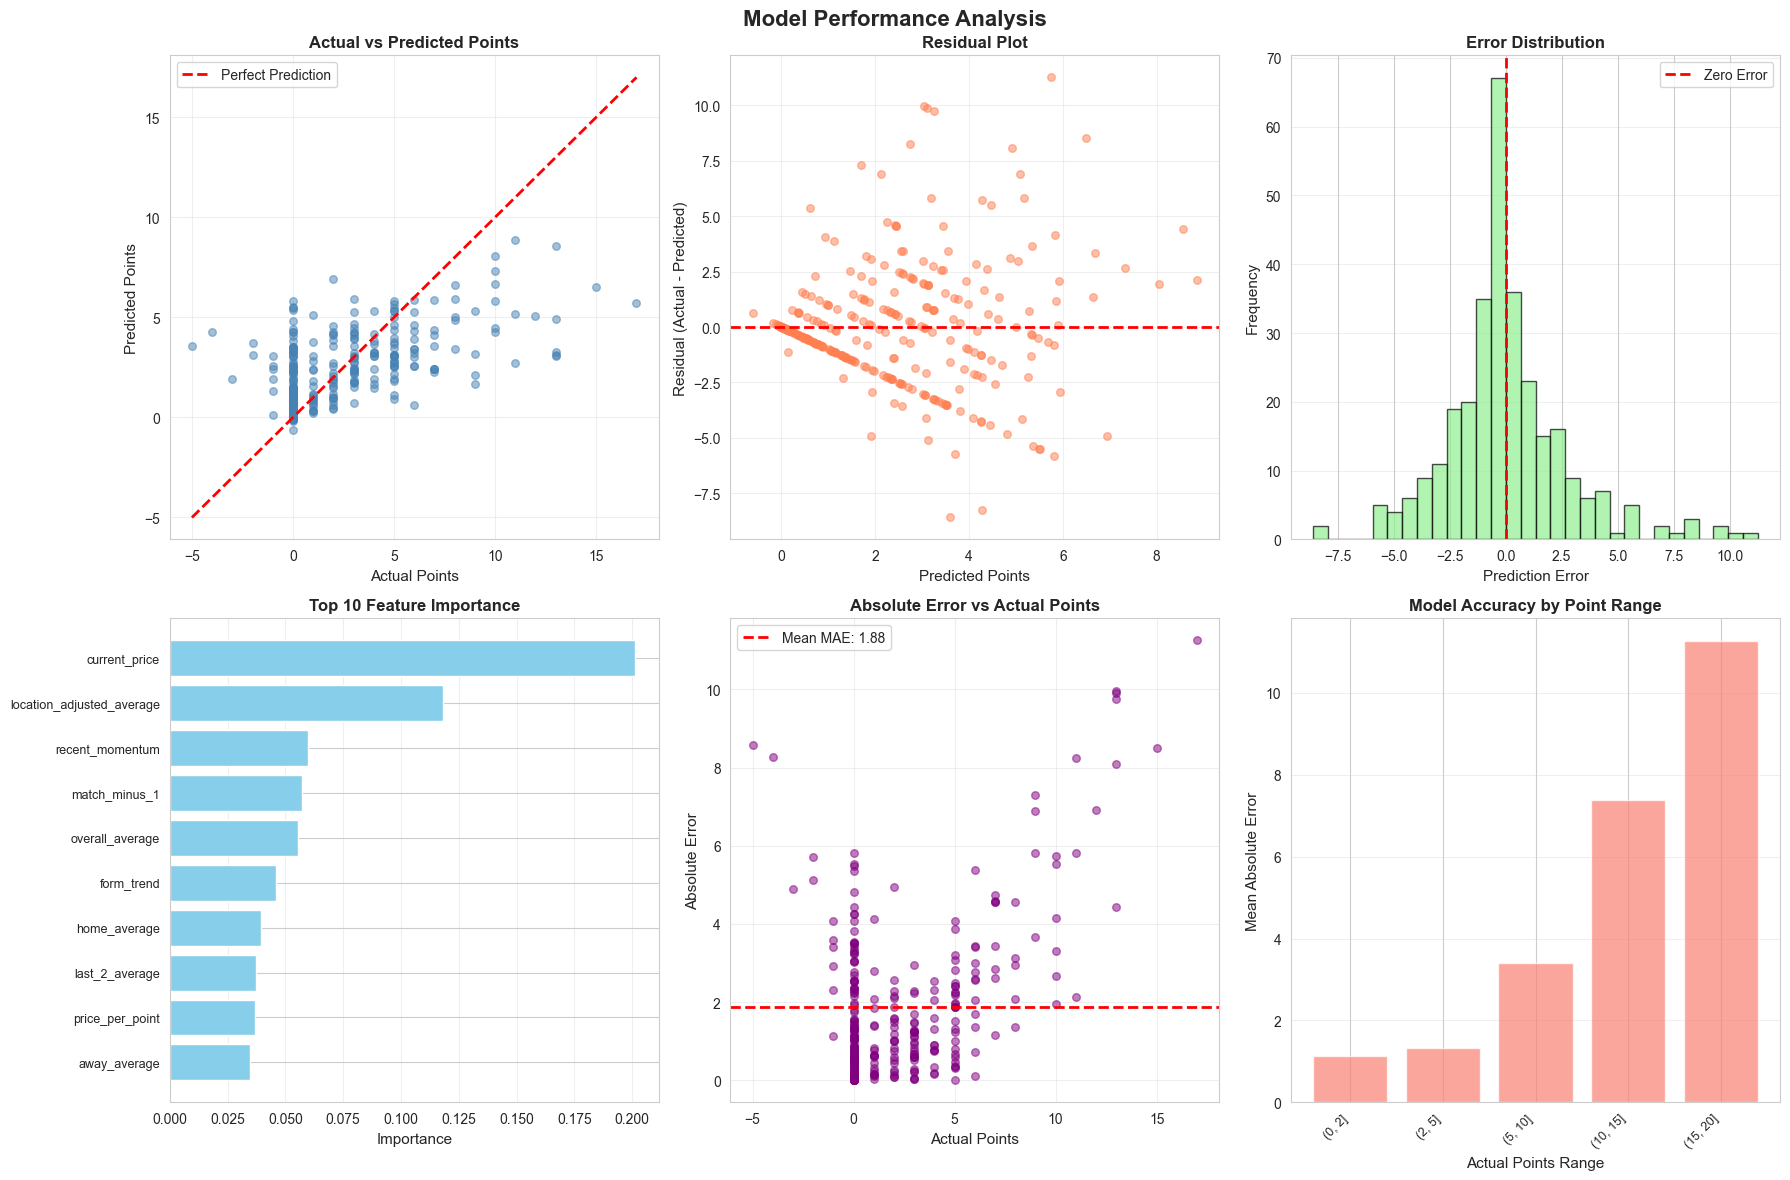


===== DETAILED PERFORMANCE METRICS =====
Mean Absolute Error (MAE): 1.877
Root Mean Squared Error (RMSE): 2.747
Median Absolute Error: 1.248
Max Error: 11.259
Predictions within 2 points: 64.4%
Predictions within 5 points: 92.5%

R² Score: 0.347


In [25]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted Scatter Plot
axes[0, 0].scatter(predictions_df['actual_points'], predictions_df['predicted_points'], 
                   alpha=0.5, s=30, c='steelblue')
# Perfect prediction line
min_val = min(predictions_df['actual_points'].min(), predictions_df['predicted_points'].min())
max_val = max(predictions_df['actual_points'].max(), predictions_df['predicted_points'].max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Points', fontsize=11)
axes[0, 0].set_ylabel('Predicted Points', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted Points', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot (errors)
axes[0, 1].scatter(predictions_df['predicted_points'], predictions_df['error'], 
                   alpha=0.5, s=30, c='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Points', fontsize=11)
axes[0, 1].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[0, 2].hist(predictions_df['error'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 2].set_xlabel('Prediction Error', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Feature Importance (Top 10)
top_features = feature_importance_df.head(10)
axes[1, 0].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 0].set_xlabel('Importance', fontsize=11)
axes[1, 0].set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 5. Absolute Error vs Actual Points
axes[1, 1].scatter(predictions_df['actual_points'], predictions_df['abs_error'], 
                   alpha=0.5, s=30, c='purple')
axes[1, 1].axhline(y=predictions_df['abs_error'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean MAE: {predictions_df["abs_error"].mean():.2f}')
axes[1, 1].set_xlabel('Actual Points', fontsize=11)
axes[1, 1].set_ylabel('Absolute Error', fontsize=11)
axes[1, 1].set_title('Absolute Error vs Actual Points', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Accuracy Bins
bins = [0, 2, 5, 10, 15, 20, 30]
predictions_df['actual_bin'] = pd.cut(predictions_df['actual_points'], bins=bins)
accuracy_by_bin = predictions_df.groupby('actual_bin', observed=True)['abs_error'].mean()
axes[1, 2].bar(range(len(accuracy_by_bin)), accuracy_by_bin.values, color='salmon', alpha=0.7)
axes[1, 2].set_xticks(range(len(accuracy_by_bin)))
axes[1, 2].set_xticklabels([str(x) for x in accuracy_by_bin.index], rotation=45, ha='right', fontsize=9)
axes[1, 2].set_xlabel('Actual Points Range', fontsize=11)
axes[1, 2].set_ylabel('Mean Absolute Error', fontsize=11)
axes[1, 2].set_title('Model Accuracy by Point Range', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional summary statistics
print("\n===== DETAILED PERFORMANCE METRICS =====")
print(f"Mean Absolute Error (MAE): {predictions_df['abs_error'].mean():.3f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt((predictions_df['error']**2).mean()):.3f}")
print(f"Median Absolute Error: {predictions_df['abs_error'].median():.3f}")
print(f"Max Error: {predictions_df['abs_error'].max():.3f}")
print(f"Predictions within 2 points: {(predictions_df['abs_error'] <= 2).sum() / len(predictions_df) * 100:.1f}%")
print(f"Predictions within 5 points: {(predictions_df['abs_error'] <= 5).sum() / len(predictions_df) * 100:.1f}%")
print(f"\nR² Score: {model.score(X_test, y_test):.3f}")

In [26]:
# Group highly correlated features and keep only the best from each group
correlation_matrix = df[feature_columns].corr()
correlation_matrix

,home_average,away_average,overall_average,last_2_average,current_price,is_home,match_minus_1,match_minus_2,matchup_prob_win,matchup_prob_draw,...,location_adjusted_average,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
home_average,1.000000,0.538709,0.834920,0.561717,0.604531,0.036932,0.460481,0.467659,0.157477,-0.078318,...,0.783353,0.147005,0.150944,0.096777,0.077587,-0.000418,-0.098026,0.096828,-0.057276,0.164591
away_average,0.538709,1.000000,0.854274,0.493712,0.490847,0.014174,0.397651,0.418129,0.108096,-0.018405,...,0.749997,0.106583,0.107389,0.083242,0.006466,0.011421,-0.039066,0.042853,-0.073725,0.100421
overall_average,0.834920,0.854274,1.000000,0.567370,0.601494,0.029591,0.460716,0.476334,0.159401,-0.063775,...,0.842733,0.151224,0.154403,0.080888,0.055244,0.019220,-0.069126,0.082843,-0.081861,0.160772
last_2_average,0.561717,0.493712,0.567370,1.000000,0.458524,0.032335,0.826712,0.826364,0.061828,-0.024195,...,0.518930,0.058804,0.059986,0.084185,0.023958,-0.045743,-0.026877,0.058657,-0.000249,0.076827
current_price,0.604531,0.490847,0.601494,0.458524,1.000000,0.003937,0.351234,0.406766,0.284432,-0.138595,...,0.552718,0.266187,0.273077,0.255100,0.136024,-0.133839,-0.064489,0.093861,-0.097848,0.321973
is_home,0.036932,0.014174,0.029591,0.032335,0.003937,1.000000,0.009287,0.044181,0.375205,-0.008832,...,0.113984,0.378773,0.378619,0.075534,0.097804,0.073625,0.024545,0.905996,-0.171107,0.177338
match_minus_1,0.460481,0.397651,0.460716,0.826712,0.351234,0.009287,1.000000,0.366330,0.040711,-0.011595,...,0.397299,0.039409,0.039957,0.063878,0.007187,-0.030069,-0.018564,0.039408,0.003920,0.039352
match_minus_2,0.467659,0.418129,0.476334,0.826364,0.406766,0.044181,0.366330,1.000000,0.061504,-0.028408,...,0.459770,0.057807,0.059214,0.075292,0.032429,-0.045555,-0.025868,0.057565,-0.004335,0.087672
matchup_prob_win,0.157477,0.108096,0.159401,0.061828,0.284432,0.375205,0.040711,0.061504,1.000000,-0.161242,...,0.207854,0.987638,0.994543,0.233271,0.206000,0.198540,0.078598,0.629931,-0.619752,0.728995
matchup_prob_draw,-0.078318,-0.018405,-0.063775,-0.024195,-0.138595,-0.008832,-0.011595,-0.028408,-0.161242,1.000000,...,-0.071585,-0.004549,-0.057398,-0.042610,-0.025965,0.004266,-0.000051,-0.134884,-0.343727,-0.344563


In [29]:
df_clean.head(2)

,player_id,name,role,round,home_average,away_average,overall_average,current_price,matches_played,rating,...,location_adjusted_average,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
0,51ffb2540ac2ec8b0700001e,Dani Rodríguez,centrocampista,13,2.0,0.0,2.000000,1000000,2,1,...,0.0,-0.528376,0.605592,0.0,0.160761,0.0,0.0,0.000000,1,0
1,52013ee178b20d7f07000351,Josan,centrocampista,13,4.4,1.5,3.571429,1000000,7,1,...,4.4,-0.570438,0.555189,0.0,0.150752,0.0,0.0,0.062813,1,0


In [ ]:
df_clean

In [8]:
from training_database import get_player_features
import pandas as pd

In [9]:
df_info=get_player_features('Witsel', 14)

In [33]:
df_info=pd.DataFrame([df_info])

In [21]:
# features_df = pd.DataFrame([df_info])